In [1]:
import os
import torch
import numpy as np
import pandas as pd
import scanpy as sc

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from pathlib import Path
from tqdm import tqdm

from adj import main, combine_graph_dict
from train import train_model
from utils import mclust_R, fix_seed

In [2]:
from sklearn.metrics import adjusted_rand_score as ari_score
from sklearn.metrics import normalized_mutual_info_score as nmi_score
from sklearn.metrics import adjusted_mutual_info_score as ami_score
from sklearn.metrics import homogeneity_score as hom_score
from sklearn.metrics import completeness_score as com_score
from utils import compute_PAS, compute_CHAOS
from sklearn.decomposition import PCA

In [3]:
fix_seed(1)

In [4]:
data_root = Path('../data/DLPFC')

proj_list = [
    '151673', '151674', '151675', '151676' 
]

In [5]:
for proj_name in tqdm(proj_list):
    adata_tmp = sc.read_visium(data_root / proj_name, count_file=proj_name+"_filtered_feature_bc_matrix.h5")
    adata_tmp.var_names_make_unique()

    adata_tmp.obs['batch_name'] = proj_name
    graph_dict_tmp = main(adata_tmp, adj_cons_by='coordinate', distType='KNN', k_cutoff=8, rad_cutoff=250)
    
    ##### Load layer_guess label, if have
    df_label = pd.read_csv(data_root / proj_name / 'manual_annotations.txt', sep='\t', header=None, index_col=0)
    df_label.columns = ['layer_guess']
    adata_tmp.obs['layer_guess'] = df_label['layer_guess']
    #adata_tmp= adata_tmp[~pd.isnull(adata_tmp.obs['layer_guess'])]
    
    if proj_name == proj_list[0]:
        adata = adata_tmp
        graph_dict = graph_dict_tmp
        name = proj_name
        adata.obs['proj_name'] = proj_name
    else:
        var_names = adata.var_names.intersection(adata_tmp.var_names)
        adata = adata[:, var_names]
        adata_tmp = adata_tmp[:, var_names]
        adata_tmp.obs['proj_name'] = proj_name
    
        adata = adata.concatenate(adata_tmp)
        graph_dict = combine_graph_dict(graph_dict, graph_dict_tmp)
        name = name + '_' + proj_name

  0%|          | 0/4 [00:00<?, ?it/s]

------Calculating spatial graph...


 25%|██▌       | 1/4 [00:01<00:03,  1.01s/it]

The graph contains 29112 edges, 3639 cells.
8.0000 neighbors per cell on average.
------Calculating spatial graph...
The graph contains 29384 edges, 3673 cells.
8.0000 neighbors per cell on average.


 50%|█████     | 2/4 [00:02<00:02,  1.24s/it]

------Calculating spatial graph...
The graph contains 28736 edges, 3592 cells.
8.0000 neighbors per cell on average.


 75%|███████▌  | 3/4 [00:03<00:01,  1.27s/it]

------Calculating spatial graph...
The graph contains 27680 edges, 3460 cells.
8.0000 neighbors per cell on average.


100%|██████████| 4/4 [00:05<00:00,  1.35s/it]


In [6]:
adata.layers['count'] = adata.X.toarray()
sc.pp.filter_genes(adata, min_cells=50)
sc.pp.filter_genes(adata, min_counts=10)
sc.pp.normalize_total(adata, target_sum=1e6)
sc.pp.highly_variable_genes(adata, flavor="seurat_v3", layer='count', n_top_genes=2000)
adata = adata[:, adata.var['highly_variable'] == True]
sc.pp.scale(adata)

from sklearn.decomposition import PCA  # sklearn PCA is used because PCA in scanpy is not stable. 
adata_X = PCA(n_components=200, random_state=42).fit_transform(adata.X)
adata.obsm['X_pca'] = adata_X

In [7]:
sedr_net = train_model(adata, graph_dict, pre_epochs=500 ,epochs=1000, mask_rate=0.2)
using_dec = False
if using_dec:
    sedr_net.train_with_dec(num_aggre=1)
else:
    sedr_net.train_without_dec()

Epoch 499 total loss=14.238: 100%|██████████ [ time left: 00:00 ]    


In [8]:
sedr_feat, _ = sedr_net.process()
adata.obsm['SEDR'] = sedr_feat

In [9]:
mclust_R(adata, num_cluster=7, used_obsm='SEDR')

R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.0.1
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%


AnnData object with n_obs × n_vars = 14364 × 2000
    obs: 'in_tissue', 'array_row', 'array_col', 'batch_name', 'layer_guess', 'proj_name', 'batch', 'mclust'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'n_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'hvg'
    obsm: 'spatial', 'X_pca', 'SEDR'
    layers: 'count'

In [10]:
#adata.write("Ours_DLPFC_151673")

In [11]:
sub_adata = adata[~pd.isnull(adata.obs['layer_guess'])]
ARI = ari_score(sub_adata.obs['layer_guess'], sub_adata.obs['mclust'])
print(f"total ARI:{ARI}")
for name in proj_list:
    sub_adata_tmp = sub_adata[sub_adata.obs['batch_name'] == name]
    ARI = ari_score(sub_adata_tmp.obs['layer_guess'], sub_adata_tmp.obs['mclust'])
    print(f"{name} ARI:{ARI}")

total ARI:0.5282974456169395
151673 ARI:0.5076967313934226
151674 ARI:0.5085149663778005
151675 ARI:0.5858257850348836
151676 ARI:0.5302860406192644


In [12]:
# sub_adata = adata[~pd.isnull(adata.obs['layer_guess'])]
# NMI = nmi_score(sub_adata.obs['layer_guess'], sub_adata.obs['mclust'])
# print(f"total NMI:{NMI}")
# for name in proj_list:
#     sub_adata_tmp = sub_adata[sub_adata.obs['batch_name'] == name]
#     NMI = nmi_score(sub_adata_tmp.obs['layer_guess'], sub_adata_tmp.obs['mclust'])
#     print(f"{name} NMI:{NMI}")

In [13]:
# sub_adata = adata[~pd.isnull(adata.obs['layer_guess'])]
# HOM = hom_score(sub_adata.obs['layer_guess'], sub_adata.obs['mclust'])
# print(f"total HOM:{HOM}")
# for name in proj_list:
#     sub_adata_tmp = sub_adata[sub_adata.obs['batch_name'] == name]
#     HOM = hom_score(sub_adata_tmp.obs['layer_guess'], sub_adata_tmp.obs['mclust'])
#     print(f"{name} HOM:{HOM}")

In [14]:
# sub_adata = adata[~pd.isnull(adata.obs['layer_guess'])]
# COM = com_score(sub_adata.obs['layer_guess'], sub_adata.obs['mclust'])
# print(f"total COM:{COM}")
# for name in proj_list:
#     sub_adata_tmp = sub_adata[sub_adata.obs['batch_name'] == name]
#     COM = com_score(sub_adata_tmp.obs['layer_guess'], sub_adata_tmp.obs['mclust'])
#     print(f"{name} COM:{COM}")

In [15]:
sub_adata = adata[~pd.isnull(adata.obs['layer_guess'])]
NMI = nmi_score(sub_adata.obs['layer_guess'], sub_adata.obs['mclust'])
print(f"total NMI:{NMI}")
AMI = ami_score(sub_adata.obs['layer_guess'], sub_adata.obs['mclust'])
print(f"total AMI:{AMI}")
for name in proj_list:
    sub_adata_tmp = sub_adata[sub_adata.obs['batch_name'] == name]
    NMI = nmi_score(sub_adata_tmp.obs['layer_guess'], sub_adata_tmp.obs['mclust'])
    AMI = ami_score(sub_adata_tmp.obs['layer_guess'], sub_adata_tmp.obs['mclust'])
    ACC = 1/2 * (NMI + AMI)
    print(f"{name} ACC:{ACC}")

total NMI:0.6295808270870403
total AMI:0.6293309092398275
151673 ACC:0.6373990773677947
151674 ACC:0.6195216918522849
151675 ACC:0.6707747740924298
151676 ACC:0.631775560558363


In [16]:
# sub_adata = adata[~pd.isnull(adata.obs['layer_guess'])]
# CHAOS = compute_CHAOS(sub_adata, f'mclust')
# print(f"total CHAOS:{CHAOS}")
# for name in proj_list:
#     sub_adata_tmp = sub_adata[sub_adata.obs['batch_name'] == name]
#     CHAOS = compute_CHAOS(sub_adata_tmp, f'mclust')
#     print(f"{CHAOS}")

In [17]:
# sub_adata = adata[~pd.isnull(adata.obs['layer_guess'])]
# PAS = compute_PAS(sub_adata, f'mclust')
# print(f"total PAS:{PAS}")
# for name in proj_list:
#     sub_adata_tmp = sub_adata[sub_adata.obs['batch_name'] == name]
#     PAS = compute_PAS(sub_adata_tmp, f'mclust')
#     print(f"{PAS}")

In [18]:
sub_adata = adata[~pd.isnull(adata.obs['layer_guess'])]
HOM = hom_score(sub_adata.obs['layer_guess'], sub_adata.obs['mclust'])
print(f"total HOM:{HOM}")
COM = com_score(sub_adata.obs['layer_guess'], sub_adata.obs['mclust'])
print(f"total COM:{COM}")
for name in proj_list:
    sub_adata_tmp = sub_adata[sub_adata.obs['batch_name'] == name]
    HOM = hom_score(sub_adata_tmp.obs['layer_guess'], sub_adata_tmp.obs['mclust'])
    COM = com_score(sub_adata_tmp.obs['layer_guess'], sub_adata_tmp.obs['mclust'])
    V =  2 * ((HOM * COM) / (HOM + COM))
    print(f"{name} V:{V}")

total HOM:0.6396271235886009
total COM:0.6198452346108445
151673 V:0.6378911926212492
151674 V:0.6200261152801346
151675 V:0.6712178653205617
151676 V:0.6322940622827051


2.810926505648111
1.2497532117811603


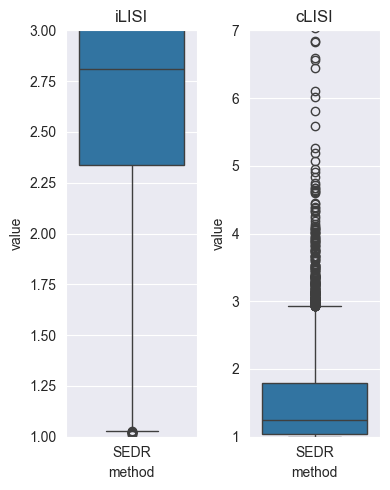

In [19]:
import harmonypy as hm

iLISI = hm.compute_lisi(adata.obsm['SEDR'], adata.obs[['batch_name']], label_colnames=['batch_name'])[:, 0]
cLISI = hm.compute_lisi(adata.obsm['SEDR'], adata.obs[['layer_guess']], label_colnames=['layer_guess'])[:, 0]
df_iLISI = pd.DataFrame({
    'method': 'SEDR',
    'value': iLISI,
    'type': ['ILISI'] * len(iLISI)
})

df_cLISI = pd.DataFrame({
    'method': 'SEDR',
    'value': cLISI,
    'type': ['CLISI'] * len(cLISI)
})

fig, axes = plt.subplots(1, 2, figsize=(4, 5))
sns.boxplot(data=df_iLISI, x='method', y='value', ax=axes[0])
sns.boxplot(data=df_cLISI, x='method', y='value', ax=axes[1])
axes[0].set_ylim(1, 3)
axes[1].set_ylim(1, 7)
axes[0].set_title('iLISI')
axes[1].set_title('cLISI')

plt.tight_layout()
print(np.median(iLISI))
print(np.median(cLISI))

In [20]:
#heatmap

In [21]:
embedding = adata.obsm['SEDR']

# 获取空间域标签
domain_labels = adata.obs['layer_guess']

df = pd.DataFrame(embedding, columns=[f'Dim{i+1}' for i in range(embedding.shape[1])])
df['Domain'] = domain_labels.values

In [22]:
# 按域计算平均值
mean_embedding_by_domain = df.groupby('Domain').mean()

# 计算 Pearson 相关系数矩阵
correlation_matrix = mean_embedding_by_domain.T.corr()

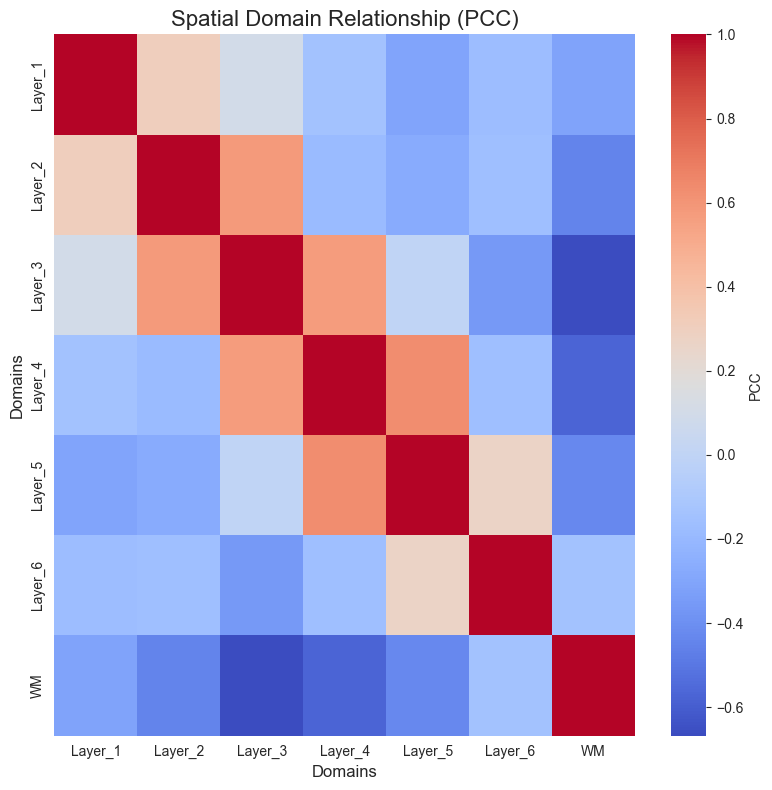

In [23]:
# 设置画布大小
plt.figure(figsize=(8, 8))

# 使用 seaborn 绘制热图
sns.heatmap(
    correlation_matrix, 
    cmap="coolwarm",       # 色带，可以选择 "coolwarm" 或 "RdBu_r"
    annot=False,           # 是否显示数字
    xticklabels=True,      # 显示横轴标签
    yticklabels=True,      # 显示纵轴标签
    cbar_kws={'label': 'PCC'}  # 添加颜色条标签
)

# 添加标题
plt.title('Spatial Domain Relationship (PCC)', fontsize=16)
plt.xlabel('Domains', fontsize=12)
plt.ylabel('Domains', fontsize=12)

# 保存图片
plt.tight_layout()
plt.savefig("domain_relationship_heatmap.png", dpi=300)
plt.show()


In [24]:
#sc.pl.correlation_matrix

In [25]:
sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=3000)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.scale(adata, zero_center=False, max_value=10)
adata=adata[:, adata.var['highly_variable']]

ValueError: b'Extrapolation not allowed with blending'

In [ ]:
sorted_indices = np.argsort(adata.obs['layer_guess'].values)
adata = adata[sorted_indices, :]

sc.pl.correlation_matrix(adata, 'layer_guess', figsize=(8,6),show=True)

In [ ]:
sc.pl.correlation_matrix(adata, 'mclust', figsize=(8,6),show=True)

In [ ]:
##find marker genes

In [ ]:
adata = sc.read_h5ad('Readout1/Ours_DLPFC_151673')

In [ ]:
# proj_list = [
#     '151507', '151508', '151509', '151510' 
# ]
# proj_list = [
#     '151669', '151670', '151671', '151672' 
# ]
proj_list = [
    '151673', '151674', '151675', '151676' 
]

In [ ]:
# sc.tl.rank_genes_groups(adata, groupby="mclust", method="wilcoxon")
# sc.pl.rank_genes_groups(adata, n_genes=20)

In [ ]:
import matplotlib.colors as clr
from scipy.sparse import issparse

In [ ]:
plt.rcParams['axes.facecolor'] = 'lightgray'  # 设置子图的背景颜色
plt.rcParams['figure.facecolor'] = 'lightgray'  # 设置整张图的背景颜色

In [ ]:
gene_list = ['TMSB10']

color_self = clr.LinearSegmentedColormap.from_list('pink_green', ['#450756', '#451464', '#426189', '#2BD32B', '#F9F871'], N=256)

In [ ]:
for name in proj_list:
    adata_tmp = adata[adata.obs['batch_name'] == name]
    print(adata_tmp)
    for gene_raw in gene_list:
        print(gene_raw in adata_tmp.var.index)  # 检查基因是否存在
        idx = adata_tmp.var.index.tolist().index(gene_raw)  #输出基因的idx
        adata_tmp.obs[f'{gene_raw}(raw)'] = np.array(adata_tmp.X[:, idx]) # 稀疏矩阵转为密集矩阵
        sc_ = sc.pl.spatial(adata_tmp, img_key="hires",
                      color=f'{gene_raw}(raw)',
                      title=gene_raw,
                      color_map=color_self,
                      spot_size=200)
        
        # plt.savefig('result/'+gene_raw+'_'+name+'.png', dpi=300)
        # plt.close()
        # 
        # print(f"Image saved as result/{gene_raw}_{name}.png")